# Adversarial attacks against Legal-BERT Model (BertForSequenceClassification)

In [ ]:
# Global variables

BATCH_SIZE = 32
MODEL_NAME = 'nlpaueb/legal-bert-small-uncased'#'bert-base-uncased'
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2
VOCABULARY_SIZE = 30522
NUM_TOKENS = 6
LIST_ID_SPECIAL_TOKENS = [0, 101, 102, 103]
LIST_SPECIAL_TOKENS = ['[PAD]', '[CLS]', '[SEP]', '[MASK]']

### Installation of packages

In [ ]:
!pip install transformers
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 4.1 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 
     |████████████████████████████████| 101 kB 11.3 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Imports

In [ ]:
import torch
import os
from transformers import BertTokenizer
from google.colab import drive
from torch.utils.data import TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import gc
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = set(stopwords.words('english'))

stemer = PorterStemmer()

special_chars = re.compile('[^⁰9a-z#+_]')
add_space = re.compile('[/(){}\[\]\\@;]')
                             
def clean_text(text):
    text = text.lower()
    text = add_space.sub(' ',text)
    text = special_chars.sub(' ',text)
    
    return re.sub(' +', ' ', text)

### Device

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():     
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### Reading dataset

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_by_lines(dir_path):

    list_filled = []
    
    with open(dir_path, "r") as file:

        for readline in file: 
            line_strip = readline.strip()
            
            if line_strip == "1": 
                list_filled.append(1) # unfair
            elif line_strip == "0":
                list_filled.append(0) # fair
            else:
                list_filled.append(clean_text(line_strip)) # sentence

    return list_filled

### You can reach to data split by this link: https://drive.google.com/drive/folders/1Y0C48PysRbc2dXHkxOmm5zgQ1w9kftYB?usp=sharing

In [ ]:
dir_train_x = "/data/train_x.txt"
dir_train_y = "/data/train_y.txt"

dir_val_x = "/data/val_x.txt"
dir_val_y = "/data/val_y.txt"

dir_test_x = "/data/test_x.txt"
dir_test_y = "/data/test_y.txt"


train_x = read_by_lines(dir_train_x)
train_y = read_by_lines(dir_train_y)

val_x = read_by_lines(dir_val_x)
val_y = read_by_lines(dir_val_y)

test_x = read_by_lines(dir_test_x)
test_y = read_by_lines(dir_test_y)

In [ ]:
print("NUMBER OF TRAIN:", len(train_x))
print("NUMBER OF VAL:", len(val_x))
print("NUMBER OF TEST:", len(test_x))

NUMBER OF TRAIN: 7060
NUMBER OF VAL: 1412
NUMBER OF TEST: 942


### Legal-Bert Tokenizer

In [ ]:
# Load the Legal-BERT tokenizer.
print('Loading Legal-BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True) # the model 'bert-base-uncased' only contains lower case sentences

Loading Legal-BERT tokenizer...


In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = NUM_CLASSES,
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at nlpaueb/legal-bert-small-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

### Model BertForSequenceClassification (Load model)

#### You can reach Legal Bert weights from: https://drive.google.com/file/d/10LaTUjut-Hus6HlP8iaWdtITv0MguIgl/view?usp=sharing

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/praktikum2/weights/legalSeqBertFineTuned_Claudette_%93_acc.pt'))

<All keys matched successfully>

### Trigger generation

##### General functions

In [ ]:
# hook used in add_hooks()
extracted_grads = []
def extract_grad_hook(module, grad_in, grad_out):
    extracted_grads.append(grad_out[0])

In [ ]:
# returns the wordpiece embedding weight matrix
def get_embedding_weight(language_model):
    for module in language_model.modules():
        if isinstance(module, torch.nn.Embedding):
            if module.weight.shape[0] == 30522:
                return module.weight.detach()

In [ ]:
# add hooks for embeddings
def add_hooks(language_model):
    for module in language_model.modules():
        if isinstance(module, torch.nn.Embedding):
            if module.weight.shape[0] == 30522:
                module.weight.requires_grad = True
                module.register_full_backward_hook(extract_grad_hook)

In [ ]:
# creates the batch of target texts with -1 placed at the end of the sequences for padding (for masking out the loss).
def make_target_batch(tokenizer, device, target_texts):
    encoded_texts = []
    max_len = 0
    for target_text in target_texts:
        encoded_target_text = tokenizer.encode_plus(
            target_text,
            add_special_tokens = True,
            max_length = EMBEDDING_SIZE - NUM_TOKENS,
            pad_to_max_length = True,
            return_attention_mask = True
        )
        encoded_texts.append(encoded_target_text.input_ids)
        if len(encoded_target_text.input_ids) > max_len:
            max_len = len(encoded_target_text)

    for indx, encoded_text in enumerate(encoded_texts):
        if len(encoded_text) < max_len:
            encoded_texts[indx].extend([-1] * (max_len - len(encoded_text)))

    target_tokens_batch = None
    for encoded_text in encoded_texts:
        target_tokens = torch.tensor(encoded_text, device=device, dtype=torch.long).unsqueeze(0)
        if target_tokens_batch is None:
            target_tokens_batch = target_tokens
        else:
            target_tokens_batch = torch.cat((target_tokens, target_tokens_batch), dim=0)
    return target_tokens_batch

In [ ]:
# Got from https://github.com/Eric-Wallace/universal-triggers/blob/master/attacks.py

def hotflip_attack(averaged_grad, embedding_matrix, trigger_token_ids,
                   increase_loss=False, num_candidates=1):
    """
    The "Hotflip" attack described in Equation (2) of the paper. This code is heavily inspired by
    the nice code of Paul Michel here https://github.com/pmichel31415/translate/blob/paul/
    pytorch_translate/research/adversarial/adversaries/brute_force_adversary.py
    This function takes in the model's average_grad over a batch of examples, the model's
    token embedding matrix, and the current trigger token IDs. It returns the top token
    candidates for each position.
    If increase_loss=True, then the attack reverses the sign of the gradient and tries to increase
    the loss (decrease the model's probability of the true class). For targeted attacks, you want
    to decrease the loss of the target class (increase_loss=False).
    """
    averaged_grad = averaged_grad.cpu()
    embedding_matrix = embedding_matrix.cpu()
    trigger_token_embeds = torch.nn.functional.embedding(torch.LongTensor(trigger_token_ids),
                                                         embedding_matrix).detach().unsqueeze(0)
    averaged_grad = averaged_grad.unsqueeze(0)
    gradient_dot_embedding_matrix = torch.einsum("bij,kj->bik",
                                                 (averaged_grad, embedding_matrix))        
    if not increase_loss:
        gradient_dot_embedding_matrix *= -1    
    if num_candidates > 1: 
        _, best_k_ids = torch.topk(gradient_dot_embedding_matrix, num_candidates, dim=2)
        return best_k_ids.detach().cpu().numpy()[0]
    _, best_at_each_step = gradient_dot_embedding_matrix.max(2)
    return best_at_each_step[0].detach().cpu().numpy()

In [ ]:
def tokenize_sentence(sentence, add_special_tokens=True):
    
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True,
                        max_length = EMBEDDING_SIZE,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    
    return encoded_dict['input_ids'], encoded_dict['attention_mask']


def decode_encode(input_id_sent):
    
    number_of_tokens = count_tokens(input_id_sent)
    sent = input_id_sent[1:number_of_tokens-1]
    decoded = tokenizer.decode(sent, add_special_tokens=False)
    input_id, attention_mask = tokenize_sentence(decoded)
    
    return input_id, attention_mask


def count_tokens(input_ids):
    
    number_of_tokens = 0  
        
    for idx in range(len(input_ids)):
        
        if input_ids[idx] != 0:
            number_of_tokens += 1
        
    return number_of_tokens

In [ ]:
def get_input_masks_and_labels_with_tokens(sentences, labels, tokens, position='B'):
    input_ids = []
    attention_masks = []
    number_of_tokens = []

    for sent in sentences:

        if position == 'B':
            
            sent_with_tokens = tokens + " " + sent
            
            input_id, attention_mask = tokenize_sentence(sent_with_tokens)
            input_ids.append(input_id)
            attention_masks.append(attention_mask)
            
        elif position == 'E':
            
            sent_with_tokens = sent + " " + tokens
            
            input_id, attention_mask = tokenize_sentence(sent_with_tokens)
            input_ids.append(input_id)
            attention_masks.append(attention_mask)
            
        else: # position given as index
            
            input_id_sent, _ = tokenize_sentence(sent)
            input_id_token, _ = tokenize_sentence(tokens)
            
            token_id = input_id_token[0][1:1+NUM_TOKENS]
                        
            position = int(position)
            
            number_of_tokens_sec_part = count_tokens(input_id_sent[0][position+1:])
            
            sec_part_sent_ids = input_id_sent[0][position+1:position+number_of_tokens_sec_part+1]
            sec_part_sent_ids = sec_part_sent_ids[:number_of_tokens_sec_part].clone()

            ## place the token ids ##
            if position+NUM_TOKENS+1 <= EMBEDDING_SIZE: # if token placement does not intersect with end of special token
                
                input_id_sent[0][position+1:position+NUM_TOKENS+1] = token_id
                end_idx = position+NUM_TOKENS+number_of_tokens_sec_part+1

                if end_idx > EMBEDDING_SIZE: # index out of range
                    
                    margin = end_idx - EMBEDDING_SIZE
                    input_id_sent[0][position+NUM_TOKENS+1:EMBEDDING_SIZE] = sec_part_sent_ids[:-margin]
                    input_id_sent[0][-1] = 102
                    
                else:
                    input_id_sent[0][position+NUM_TOKENS+1:end_idx] = sec_part_sent_ids 
                    
                input_id, attention_mask = decode_encode(input_id_sent[0])
                input_ids.append(input_id)
                attention_masks.append(attention_mask)
                        
            else: # apply end of sentence operation
                
                new_position = EMBEDDING_SIZE - NUM_TOKENS -1

                input_id_sent[0][new_position:-1] = token_id
                input_id_sent[0][-1] = 102
                
                input_id, attention_mask = decode_encode(input_id_sent[0])
                input_ids.append(input_id)
                attention_masks.append(attention_mask)

                
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # count number of tokens of each sentence
    for idx in range(len(input_ids)):
        sent_ids = input_ids[idx, :]

        cnt = 0
        for id_ in sent_ids:
            if id_ != 0:
                cnt += 1

        number_of_tokens.append(cnt)
    
    return input_ids, attention_masks, labels, number_of_tokens

In [ ]:
def get_loss_and_metrics(model, dataloader, device, train_mode=True):
    # get initial loss for the trigger
    #if train_mode:
    model.zero_grad()
    #else:
    #    model.eval()

    test_preds = []
    test_targets = []

    # Tracking variables 
    total_test_accuracy = 0
    total_test_loss = 0
    io_total_test_acc = 0
    io_total_test_prec = 0
    io_total_test_recall = 0
    io_total_test_f1 = 0

    for batch in dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #model.zero_grad()

        result = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels,
                    return_dict=True)

        loss = result.loss
        logits = result.logits

        test_preds.extend(logits.argmax(dim=1).cpu().numpy())
        test_targets.extend(batch[2].numpy())

        # Accumulate the validation loss.
        total_test_loss += loss.item()

        test_preds.extend(logits.argmax(dim=1).cpu().numpy())
        test_targets.extend(batch[2].numpy())

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #if train_mode:
        loss.backward()        

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.        
        test_acc = accuracy_score(test_targets, test_preds)
        test_precision = precision_score(test_targets, test_preds)
        test_recall = recall_score(test_targets, test_preds)
        test_f1 = f1_score(test_targets, test_preds)

        io_total_test_acc += test_acc
        io_total_test_prec += test_precision
        io_total_test_recall += test_recall
        io_total_test_f1 += test_f1

    io_avg_test_loss = total_test_loss/len(dataloader)
    io_avg_test_acc = io_total_test_acc / len(dataloader)
    io_avg_test_prec = io_total_test_prec / len(dataloader)
    io_avg_test_recall = io_total_test_recall / len(dataloader)
    io_avg_test_f1 = io_total_test_f1 / len(dataloader)

    if train_mode:
      print(
              f'Loss {io_avg_test_loss} : \t\
              Train_acc : {io_avg_test_acc}\t\
              Train_F1 : {io_avg_test_f1}\t\
              Train_precision : {io_avg_test_prec}\t\
              Train_recall : {io_avg_test_recall}'
            )
    """
    else:
      print(
              f'Loss {io_avg_test_loss} : \t\
              Valid_acc : {io_avg_test_acc}\t\
              Valid_F1 : {io_avg_test_f1}\t\
              Valid_precision : {io_avg_test_prec}\t\
              Valid_recall : {io_avg_test_recall}'
            )
    """
    return io_avg_test_loss, io_avg_test_acc, io_avg_test_prec, io_avg_test_recall, io_avg_test_f1

In [ ]:
def change_input_ids_with_candidate_token(input_ids, position, candidate, number_of_tokens, trigger_position='B'):
    if trigger_position == 'B':
        input_ids[:, position] = candidate
        
    elif trigger_position == 'E':
      
        for idx in range(len(input_ids)):

            if number_of_tokens[idx] > EMBEDDING_SIZE:
                input_ids[idx, EMBEDDING_SIZE-NUM_TOKENS-2+position] = candidate
            else:
                input_ids[idx, number_of_tokens[idx]-NUM_TOKENS-2+position] = candidate
                
    else: # position is given as index
        token_pos = int(trigger_position)
        input_ids[:, token_pos+position-1] = candidate
        
    return input_ids

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
######################## TRAIN DATASET ###########################
positions_unfair_train = np.where(np.array(train_y) == 1)[0]
print(f'First 32 positions: {positions_unfair_train[0:32]} with total of unfair sentences {len(positions_unfair_train)}')

target_unfair_sentences_train = []
labels_unfair_sentences_train = []
for index in range(len(positions_unfair_train)):
    target_unfair_sentences_train.append(train_x[positions_unfair_train[index]])
    labels_unfair_sentences_train.append(train_y[positions_unfair_train[index]])


######################## VALIDATION DATASET ###########################
positions_unfair_val = np.where(np.array(val_y) == 1)[0]
print(f'First 32 positions: {positions_unfair_val[0:32]} with total of unfair sentences {len(positions_unfair_val)}')

target_unfair_sentences_val = []
labels_unfair_sentences_val = []

for index in range(len(positions_unfair_val)):
    target_unfair_sentences_val.append(val_x[positions_unfair_val[index]])
    labels_unfair_sentences_val.append(val_y[positions_unfair_val[index]])

First 32 positions: [  2   7  15  32  42  52  53  55  69  73  75  77  83 117 124 130 132 136
 140 144 152 155 169 175 185 190 212 216 222 229 235 243] with total of unfair sentences 774
First 32 positions: [  5  16  20  24  28  32  36  37  43  44  61  62  74  96 100 105 106 124
 142 153 199 211 222 226 244 282 284 285 291 292 321 325] with total of unfair sentences 155


In [ ]:
model.eval()
model.to(device)

add_hooks(model) # add gradient hooks to embeddings
embedding_weight = get_embedding_weight(model) # save the word embedding matrix

In [ ]:
trigger_tokens = np.array([207]*NUM_TOKENS)
print(tokenizer.decode(trigger_tokens))

the the the the the the


In [ ]:
position = 'E'
#position = 'B'
#position = '3'

##################### TRAIN DATALOADER #############################
train_input_ids, train_attention_masks, train_labels, train_number_of_tokens = get_input_masks_and_labels_with_tokens(target_unfair_sentences_train, labels_unfair_sentences_train, tokenizer.decode(trigger_tokens), position=position)
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

##################### VAL DATALOADER #############################
val_input_ids, val_attention_masks, val_labels, val_number_of_tokens = get_input_masks_and_labels_with_tokens(target_unfair_sentences_val, labels_unfair_sentences_val, tokenizer.decode(trigger_tokens), position=position)
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
extracted_grads = []

train_loss_obtained, train_acc_obtained, train_prec_obtained, train_recall_obtained, train_f1_obtained = get_loss_and_metrics(model, train_dataloader, device, train_mode=True)

print(f'train loss_obtained {train_loss_obtained}')

candidates_selected = [0]*NUM_TOKENS
# try all the candidates and pick the best
curr_best_train_loss = train_loss_obtained
curr_best_trigger_tokens = None

train_loss_list = []
train_acc_list = []
train_prec_list = []
train_recall_list = []
train_f1_list = []

val_loss_list = []
val_acc_list = []
val_prec_list = []
val_recall_list = []
val_f1_list = []

for id_token_to_flip in range(0, NUM_TOKENS):

    averaged_grad = torch.sum(extracted_grads[0], dim=0)
    averaged_grad = averaged_grad[id_token_to_flip].unsqueeze(0)

    # Use hotflip (linear approximation) attack to get the top num_candidates
    candidates = hotflip_attack(averaged_grad, embedding_weight,
                                        [trigger_tokens[id_token_to_flip]], 
                                        increase_loss=False, num_candidates=200)[0]
    print(f'candidates {candidates}')
    
    for index, cand in enumerate(candidates):
        extracted_grads = []

        if cand in LIST_ID_SPECIAL_TOKENS:
          continue

        input_ids_with_candidate_trigger = change_input_ids_with_candidate_token(deepcopy(train_input_ids), id_token_to_flip+1, cand, train_number_of_tokens, trigger_position=position)
        dataset_with_candidate_trigger = TensorDataset(input_ids_with_candidate_trigger, train_attention_masks, train_labels)
        dataloader_with_candidate_trigger = torch.utils.data.DataLoader(dataset_with_candidate_trigger, batch_size=BATCH_SIZE)

        current_loss_train, current_acc_train, current_prec_train, current_recall_train, current_f1_train = get_loss_and_metrics(model, dataloader_with_candidate_trigger, device, train_mode=True)


        if curr_best_train_loss < current_loss_train:
          
            train_loss_list.append(current_loss_train)
            train_acc_list.append(current_acc_train)
            train_prec_list.append(current_prec_train)
            train_recall_list.append(current_recall_train)
            train_f1_list.append(current_f1_train)

            curr_best_train_loss = current_loss_train
            candidates_selected[id_token_to_flip] = cand

            ######### VALIDATION ##########
            
            input_ids_with_candidate_trigger = change_input_ids_with_candidate_token(deepcopy(val_input_ids), id_token_to_flip+1, cand, val_number_of_tokens, trigger_position=position)
            dataset_with_candidate_trigger = TensorDataset(input_ids_with_candidate_trigger, val_attention_masks, val_labels)
            dataloader_with_candidate_trigger = torch.utils.data.DataLoader(dataset_with_candidate_trigger, batch_size=BATCH_SIZE)

            current_loss_val, current_acc_val, current_prec_val, current_recall_val, current_f1_val = get_loss_and_metrics(model, dataloader_with_candidate_trigger, device, train_mode=False)

            val_loss_list.append(current_loss_val)
            val_acc_list.append(current_acc_val)
            val_prec_list.append(current_prec_val)
            val_recall_list.append(current_recall_val)
            val_f1_list.append(current_f1_val)
            

        del input_ids_with_candidate_trigger
        del dataset_with_candidate_trigger
        del dataloader_with_candidate_trigger

        gc.collect()
        torch.cuda.empty_cache()

        print(f'[{id_token_to_flip}][{index}] loss[{index}] {current_loss_train} ({curr_best_train_loss})')

    print(f'Worst Train Loss {curr_best_train_loss} with candidates {candidates_selected}')
    print(f'Worst Validation Loss {current_loss_val} with candidates {candidates_selected}')

    train_input_ids = change_input_ids_with_candidate_token(deepcopy(train_input_ids), id_token_to_flip+1, candidates_selected[id_token_to_flip], train_number_of_tokens, trigger_position=position)

Loss 0.4920546066761017 : 	              Train_acc : 0.8269299985212245	              Train_F1 : 0.9051792871486686	              Train_precision : 1.0	              Train_recall : 0.8269299985212245
train loss_obtained 0.4920546066761017
candidates [15425 21061 17804 19388  5714 23088 14383  9361  9592 25299 21358 29956
  3019 20895  9148  1414   625 22567 21262 22545  7380 25566 25164  3134
 10893 21964 27798 30198 28287  3497  9884 27122 10958 10830 28970  9110
 24404 26073 14889 14850 16807 21710 26798  3375 18251  4402 23592 14282
 25757 17017 20432 11223  8644 28824  3709 29375 21766 29655  5102 13745
 21224  8347 14278  7716 14486 22129 15703  6966  6749 23490  6019 22742
 20012 24099 10270 16396 17700  8756 21418 11144  6246 17205 29628  7827
 26226 21246 27101  9080  8501  7493  5848 13607 24825  4730 30151  8099
  6320  8268 20513 16227 21720 22137 21932 24251 15550 17932  2208 21059
  3330 17294 29588 21458 16934 30029 30354  5340  1309 26531 22720 13189
 18183 26543 26931  

In [ ]:
#print(tokenizer.encode("the the the")) #[101, 207, 207, 207, 102]
#print(tokenizer.decode([621, 13890, 21241, 23113, 221, 1898]))# Loss => unless communist normativ encroachments as anything
#print(tokenizer.decode([621, 13890, 13064, 1897, 1629, 29403]))# Accuracy => unless communist tolerate political dismissed disjunctive
#print(tokenizer.decode([621, 13890, 13064, 1897, 1629, 22121]))# F1 => unless communist tolerate political dismissed symmetrical

In [ ]:
print(tokenizer.decode([14850, 23695, 3176, 13817, 21633, 514])) # Loss => retrospectively determinant history analyzing capitation closing

retrospectively determinant history analyzing capitation closing


In [ ]:
print(tokenizer.decode([14850, 23695, 3176, 13817, 21633, 514])) # Loss => retrospectively determinant history analyzing capitation closing
#14850, 23695, 3176, 13817, 21633, 514

retrospectively determinant history analyzing capitation closing


In [ ]:
print(tokenizer.decode([1297, 17560, 12674, 1158, 7691, 3284]))

signature scarcely differentiati context combating quoting


## Test BERT model with tokens

In [ ]:
test_sentences = test_x.copy()
test_labels = test_y.copy()

In [ ]:
token_6 = "assume defense differentiati failure combating  advocate"
position = "E"

In [ ]:
input_ids, attention_masks, labels, _ = get_input_masks_and_labels_with_tokens(test_sentences, test_labels, token_6, position)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    #print("logits: ", logits[0])
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
    predictions += list(np.argmax(logits, axis=1).flatten())
    true_labels += list(label_ids)

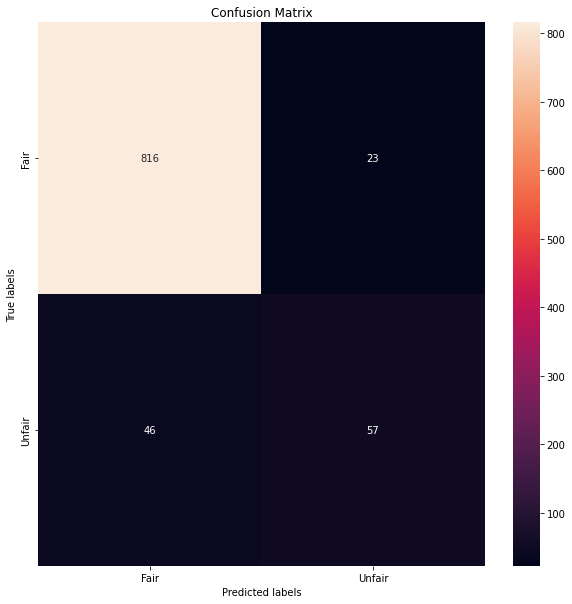

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10)) 
conf_matrix = confusion_matrix(y_true=true_labels, y_pred=predictions)
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Fair', 'Unfair']); 
ax.yaxis.set_ticklabels(['Fair', 'Unfair']);

In [ ]:
target_names=['Fair', 'Unfair']
print(classification_report(true_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

        Fair       0.95      0.97      0.96       839
      Unfair       0.71      0.55      0.62       103

    accuracy                           0.93       942
   macro avg       0.83      0.76      0.79       942
weighted avg       0.92      0.93      0.92       942

